# Cox Regression: Deconstructed

What are the most probable parameters that explain rank-ordered times to event?

## Introduction

The goal of Cox regression model is to asses the relationship of predictor variables to time-to-event of some event that can occur at most once - for example, death. We will start by creating a simple simulated dataset, with 5 subjects labeled A to E. Each subject either experienced an event or not, during the duration of the study. Each subject also has a predictor $x$, assigned before the study. For example, this could be a level of a drug tested to prolong longevity:

In [1]:
import pandas as pd
import numpy as np

sample_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 5, 4, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [-1.7, -0.4, 0.0, 0.9, 1.2],
})

sample_df

,subject,time,event,x
0,A,1,1,-1.7
1,B,3,1,-0.4
2,C,5,1,0.0
3,D,4,1,0.9
4,E,6,0,1.2


If a subject experienced an event (event = 1), the `time` column indicates its event time. Subjects who do not experience an event (event = 0) throughout the study are called "censored", and have `time` as the last time we have information on them. If there are no censored subjects, `event` column will be 1 for all subjects and becomes reduntant. However, most statistical libraries still require having it.

In order to better visualize the events, we use a "lollipop" 🍭 plot:

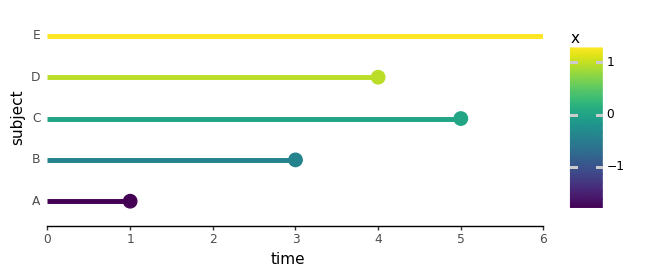

<ggplot: (8756426771634)>

In [2]:
from cox.plots import plot_subject_event_times
plot_subject_event_times(sample_df)

On this plot, lines indicate the duration of time each subject experienced before an event, which is represented by a filled circle. Subject E does not have a circle since it survived the entire study. Color gradient represent levels of predictor $x$.

Note: Throughout this post, we will focus on datasets where only one event occurs at each time (no "ties"). This simplification allows for a clearer understanding of the core of the Cox model.

## Hazards

Hazard represents the probability of an event occurring per specific unit of time - assuming that the event did not occur before and that it can occur at most once. Hazard signifies the _rate_ at which events take place and can have arbitrary units for time. Therefore, unlike probability, hazard values can span from 0 to ∞.

Hazard, $h(t, x)$, is modeled in a similar spirit to the odds in logistic regression. In logistic regression, odds = p/(1-p), transforms a range of values [0, 1], to a range [0, ∞). Logarithm then transforms odds into log-odds with range (-∞, ∞). This log-odds transformation of probabilities is done to match the range of possible output values to the ones from linear combinations of predictor variables ($\beta_1 x_1 + \beta_2 x_2 + ...$), which are also (-∞, ∞).

Here, the possible values of hazard are [0, ∞), so logarithm will transform that to (-∞, ∞), which will match the possible value range of linear combination of predictors:

$$\log h(t, x) = \beta x + \beta_0$$

In previous posts on logistic regression, we noticed this type of log-probabilistic model could not fit perfectly separable data, which resulted in infinite odds ratios. We will investigate what happens in a similar situation here later.

In addition to the assumption of log-hazards having linear relationship with predictors, Cox regression also assumes that any time dependence of log-hazard is contained _only_ in the intercept term, $\beta_0(t)$:

$$\log h(t, x) = \beta x + \beta_0(t)$$

This assumption is motivated mathematically - we will show in a moment how it significantly simplifies the fitting process. It also happens to work well in practice. Across the literature, the intercept term $\beta_0(t)$ is usually moved to the left side of this equation and instead expressed as a _baseline hazard_ $\log[h_0(t)]$:

$$\log\left[\frac{h(t, x)}{h_0(t)}\right] = \beta x$$

From this equation, we can expressed the hazard $h(t, x)$:

$$h(t, x) = h_0(t) e^{\beta x}$$

The data from each subject only enters through predictors $x$, so each subject follows has the same time dependency of the hazard, up to $e^{\beta x}$ term. Therefore, Cox model is also called a "proportional hazard" model. Still, this equation does not seem particularly useful, as it seems like we now also need a mathematical model for the baseline hazard $h_0(t)$?

## How do we get $\beta$ ?

It turns out, we can leave this pesky baseline hazard $h_0(t)$ undefined or arbitrary, as it will completely cancel out when fitting a model, using a technique called Maximum Likelihood Estimation (MLE). Likelihood is a probability of observing the data given model parameters (here $\beta$) - same equation for probability but with $\beta$ as a variable. (Imagine a Normal distribution but instead viewing it as a function of $x$, plot it as a function of $\mu$ and $\sigma$.)

MLE takes the event times as a given constraint: it assumes that _some event_ did 100% occur at each time point. We then want to estimate how likely is it that the subject we observed underwent an event at that time point, versus all other subjects that were _still at risk_ of undergoing an event. For example, at t = 1 we are pitting the hazard of subject A against the combined hazard (rate) of everyone else who is still at risk:

$$L_A = \frac{h_A}{h_A + h_B + h_C + h_D + h_E}$$

$$L_A = \frac{h_0(t) e^{\beta x_A}}{h_0(t) e^{\beta x_A} + h_0(t) e^{\beta x_B} + h_0(t) e^{\beta x_C} + h_0(t) e^{\beta x_D} + h_0(t) e^{\beta x_E}}$$

Our undefined baseline hazard $h_0(t)$ can be cancelled out from this expression, hence the reason for not modeling it earlier. After plugging in each subject's values for $x$ ([-1.7, -0.4, 0.0, 0.9, 1.2]), we can get an expression for likelihood that only contains $\beta$ s.

$$L_A = \frac{e^{\beta \cdot 0}}{e^{\beta \cdot 0} + e^{\beta \cdot 0} + e^{\beta \cdot 0} + e^{\beta \cdot 1} + e^{\beta \cdot 1}} = \frac{1}{3 + 2e^{\beta}}$$

For times after t = 1, hazard of subject A is defined as zero, so subject A gets excluded from calculating likelihoods of events that occur after t = 1. This is because events considered here occur at most once, and subject A already experienced the event; they are out of the picture. For example at, another time t = 3, subject B undergoes an event:

$$L_B = \frac{h_B}{h_B + h_C + h_D + h_E} = \frac{1}{2 + 2e^{\beta}}$$

We keep going until we write down likelihoods for all subjects that experienced an event. Subject E never experienced an event during our simulated study (subject is "censored"), so we do not write any separate likelihood for it. The information from censored subjects is only partially used: we put $h_E$ in other hazards, but we do not have a separate likelihood for it. 

We can animate our lollipop plot to visualize this entire process:

In [3]:
from cox.plots import animate_subject_event_times_and_mark_at_risk
animate_subject_event_times_and_mark_at_risk(
    sample_df
).save('../images/cox_likelihood_fitting_sample.gif')

![Cox likelihood fitting animation](../images/cox_likelihood_fitting_sample.gif)

#### Find $\beta$ for which sum of log-likelihoods is maximal

If each event occurs independently of each other, then the joint probability (likelihood) of observing all events given some parameters $\beta$, is the product of individual likelihoods $L = L_A L_B L_C L_D$. However, products of many expressions that contain exponential functions can produce very large numbers and can lead to large numerical errors. Therefore, this likelihood is log-transformed, because logarithm turns a product of likelihoods into sum of log-likelihoods:

$$\log L = \log L_A + \log L_B + \log L_C + \log L_D$$

$$\log L_A = \beta x_A - \log \left(e^{\beta x_A} + e^{\beta x_B} + e^{\beta x_C} + e^{\beta x_D} + e^{\beta x_E}\right)$$

The fitting process then tries to find $\beta$ s that maximize this sum of log-likelihoods. Alternatively, to make this comparable to cost functions we are familiar with from linear and logistic regressions, we could define cost as negative log-likelihood and then minimize the cost.

Finally, since the data on censored subjects is only partially used, in the total at-risk hazards of each likelihood, this full likelihood in Cox model is also called a "partial likelihood".

Also you may have noticed that the only use of event times in this entire process was to construct total at-risk hazards in the denominators of likelihoods. In fact, the **actual numeric values of event times do not matter at all, only their ranks with respect to subjects**. In our example, as long as subjects undergo events in the order A, B, D, C, with E censored, we can put whatever numerical values we want for times and Cox model will be unaffected.

## How do we implement this?

We can implement this algorithm in Python. Since we are iterating per each subject, we first need to find event time and a predictor $x$ of each subject - this is done using `event_time_and_x_from_subject()`. Next, using the event time of that subject, we subset our data frame to find rows for each subject that is _still at risk_ - this is done using `subjects_at_risk_data()`. Finally, the log-likelihood of that subject is calculated using `log_likelihood` based on the last equation:

In [4]:
def event_time_and_x_from_subject(df, subject):
    subject_with_event_df = df.query(f"subject == '{subject}' & event == 1")
    if subject_with_event_df.empty: # For censored subjects return infinite time
        return (np.inf, 0)
    return subject_with_event_df.iloc[0][['time', 'x']]

def subjects_at_risk_data(df, subject):
    time = event_time_and_x_from_subject(df, subject)[0]
    return df.query(f'time >= {time}')

def log_likelihood(df, subject, beta):
    x_subjects_at_risk = subjects_at_risk_data(df, subject)['x']
    x_subject = event_time_and_x_from_subject(df, subject)[1]
    at_risk_hazards = np.exp(beta * x_subjects_at_risk)
    return beta * x_subject - np.log(np.sum(at_risk_hazards))

For visualization purposes we will be plotting the "cost" or negative log-likelihoods, so we need to calculate those for each subject for specific value of $\beta$:


In [5]:
def neg_log_likelihood_for_all_subjects(df, beta):
    subjects = df.query("event == 1")['subject'].tolist()
    neg_log_likelihoods = [-log_likelihood(df, subject, beta) for subject in subjects]
    return pd.DataFrame({
        'subject': subjects,
        'neg_log_likelihood': neg_log_likelihoods
    })

In order to find the minimum of this cost, as a function of $\beta$ we need to sweep a range of $\beta$ s. Finally, instead of aggregating this data frame by summing log-likelihoods (grouped by subject), we will leave them as they are, but plot them as stacked bar charts. Then the total height of each bar represents the sum of negative log-likelihoods:

In [16]:
def neg_log_likelihood_all_subjects_sweep_betas(df, betas=np.arange(-5, 5, 0.1)):
    loglikelihoods_per_beta = []
    for beta in betas:
        beta_df = neg_log_likelihood_for_all_subjects(df, beta)
        beta_df.insert(0, 'beta', beta) # Add beta column
        loglikelihoods_per_beta.append(beta_df)
    return pd.concat(loglikelihoods_per_beta)

negloglik_sweep_betas_df = neg_log_likelihood_all_subjects_sweep_betas(sample_df)
negloglik_sweep_betas_df

,beta,subject,neg_log_likelihood
0,-5.0,A,0.001708
1,-5.0,B,0.128546
2,-5.0,C,0.002476
3,-5.0,D,4.513496
0,-4.9,A,0.001955
...,...,...,...
3,4.8,D,1.655175
0,4.9,A,14.419543
1,4.9,B,8.049543
2,4.9,C,5.882791


## Making sense of it all

Here's a plot of the negative log-likelihoods, grouped by subject-level likelihoods to indicate each contribution to the total:

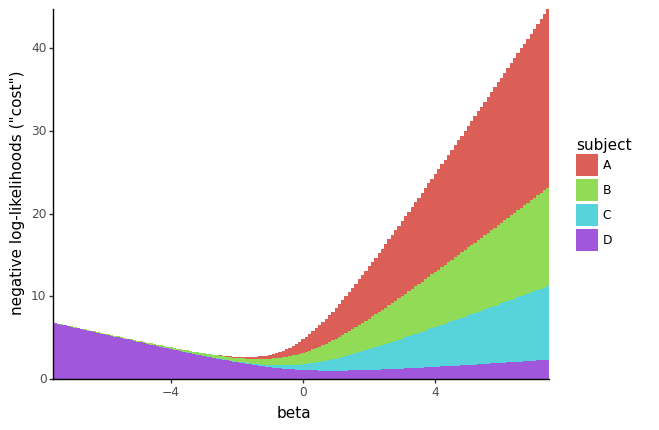

<ggplot: (8756424503637)>

In [15]:
from cox.plots import plot_cost_vs_beta
plot_cost_vs_beta(negloglik_sweep_betas_df, width=0.1)

How do we read this plot?

First, each vertical colored bar represents the individual negative log-likelihood. **Negative log-likelihood (cost) is large when the likelihood and hazards are small.** If a proportion of each subject's hazard is small compared to hazards of all subjects at risk, we have a large cost. Think of the y axis very similar to $-\log(\text{p-value})$; larger values = lower probability. Second, all censored subjects (here only subject E) do not have their own likelihoods so they do not show up on the plot. Their contribution is "built in" likelihoods of A to D.

If $\beta$ is large and negative, subjects A, B and C (with x <= 0) and their events are fit near-perfectly: the likelihoods of them experiencing events at times 1, 2 and 5 are all near one. In fact, we could create arbitrarily good fit for subjects A,B and C by having $\beta$ more and more negative. However, the cost of doing that is the hazard for subject D. In that range of $\beta$ the probability of subject D (x > 0) having an event at t = 4 is very low. The end resuls is that total cost is dominated by the small likelihood of subject D.

On the other hand, if $\beta$ is large and positive, hazard of subject D (with $x > 0$) is now large compared to the other hazards (purple is a small part of the total). However, A, B and C all have $x \leq 0$, so the cost of fitting large $\beta$ for A, B and C is high, and these subject snow dominate the total cost.

The middle ground or the optimal value of $\beta$ (around 2 on our plot) strikes a balance between assigning high probabilities to events of subjects A, B, C vs subject D. We can verify this numerically:

In [17]:
negloglik_sweep_betas_df \
    .groupby("beta") \
    .agg(sum_neg_log_likelihood=('neg_log_likelihood', 'sum')) \
    .reset_index() \
    .sort_values('sum_neg_log_likelihood') \
    .head(1)

,beta,sum_neg_log_likelihood
33,-1.7,2.63925


## Running Cox regressions

Now that we have a better idea of the concepts behind how Cox regression works, we can use Python's `lifelines` library on sample data to verify the results:

In [18]:
from lifelines import CoxPHFitter

sample_cox_model = CoxPHFitter()
sample_cox_model.fit(sample_df, duration_col='time', event_col='event', formula='x')
sample_cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -2.64
         time fit was run = 2023-06-04 22:18:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -1.71       0.18       1.07            -3.81             0.38                 0.02                 1.46

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.60 0.11       3.20
---
Concordance = 0.90
Partial AIC = 7.28
log-likelihood ratio test = 4.30 on 1 df
-log2(p) of ll-ratio test = 4.71

We can see the `coef = -1.71`, which is a $\beta$ coefficient. Next to it are `exp(coef)` which represents $e^{\beta}$, and other columns that indicate standard errors and confidence intervals of both. Note that "partial log-likelihood" is -2.64, which is inline to the number we obtained manually. One last thing to note is that Cox regression implementations include an extension that allows the model to work with multiple events tied on the same event time.